# ROF monthly, annual, seasonal discharge at ocean outlets <a id='top'></a>

Use the following datasets

1. reach-D19 gauge link ascii
2. D19 flow site geopackage
3. D19 discharge netCDF
4. monthly and yearly flow netCD (history file)

[1. Setup](#configuration)


[2. Loading discharge data](#load_q)

- Read monthly history files from archive. 
- Reference data: monthly discharge estimates at 922 big river mouths from Dai et al. 2019 data (D19)

[3. Read river, catchment, gauge information](#read_ancillary)

- catchment polygon (geopackage)
- gauge point (geopackage)
- gauge-catchment link (csv)
- outlet reach information (netCDF) including discharging ocean names

[4. Ocean discharge line plots](#annual_cycle_q)

- total seasonal flow for oceans. 

[5. Plot zonal mean annual dicharge to the oceans](#zonal_mean_annual_q)

- total seasonal flow for oceans. 

In [1]:
%matplotlib inline

import os, sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import cartopy.feature as cfeature

from scripts.utility import load_yaml
from scripts.utility import no_time_variable
from scripts.utility import read_shps
from scripts.utility import get_index_array

rivers_50m = cfeature.NaturalEarthFeature("physical", "rivers_lake_centerlines", "50m")
land = cfeature.LAND

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)
print(pd.__name__, pd.__version__)
print(gpd.__name__, gpd.__version__)


The Python version: 3.11.4
xarray 2025.6.1
pandas 2.3.3
geopandas 1.1.1


ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/tking/conda-envs/cupid-analysis/share/proj failed


-------------------------
## 1. Setup <a id='configuration'></a>

In [2]:
# Parameter Defaults
# parameters are set in CUPiD's config.yml file
# when running interactively, manually set the parameters below

CESM_output_dir = ""
case_name = None  # case name: e.g., "b.e30_beta02.BLT1850.ne30_t232.104"
base_case_name = None  # base case name: e.g., "b.e23_alpha17f.BLT1850.ne30_t232.092"
base_case_output_dir = None
start_date = ""
end_date = ""
base_start_date = ""  # base simulation starting date: "0001-01-01"
base_end_date = ""  # base simulation ending date: "0100-01-01"
serial = True  # use dask LocalCluster
lc_kwargs = {}

hist_str = ""  # Used for hist file tag
analysis_name = ""  # Used for Figure png names
climo_nyears = 10  # number of years to compute the climatology
grid_name = "f09_f09_mosart"  # ROF grid name used in case
base_grid_name = (
    grid_name  # spcify ROF grid name for base_case in config.yml if different than case
)
figureSave = False

In [3]:
# Parameters
case_name = "b.e30_alpha07c_cesm.B1850C_LTso.ne30_t232_wgx3.241"
base_case_name = "b.e30_alpha07c_cesm.B1850C_LTso.ne30_t232_wgx3.234"
case_nickname = "BLT1850_241"
base_case_nickname = "BLT1850_234"
CESM_output_dir = "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CESM_output_for_testing"
start_date = "0001-01-01"
end_date = "0041-01-01"
climo_start_year = 21
climo_end_year = 41
base_start_date = "0001-01-01"
base_end_date = "0081-01-01"
base_climo_start_year = 61
base_climo_end_year = 81
obs_data_dir = (
    "/glade/campaign/cesm/development/cross-wg/diagnostic_framework/CUPiD_obs_data"
)
ts_dir = None
lc_kwargs = {"threads_per_worker": 1}
serial = False
hist_str = "h0a"
analysis_name = ""
grid_name = "f09_f09_mosart"
climo_nyears = 10
figureSave = False
subset_kwargs = {}
product = "/glade/work/tking/cupid_project/other_cupids/234v241/CUPiD/examples/key_metrics/computed_notebooks//rof/global_discharge_ocean_compare_obs.ipynb"


In [4]:
if base_case_output_dir is None:
    base_case_output_dir = CESM_output_dir

In [5]:
# ROF additional setup
setup = load_yaml("./setup/setup.yaml")

domain_dir = setup[
    "ancillary_dir"
]  # ancillary directory including such as ROF domain, river network data
geospatial_dir = setup["geospatial_dir"]  # including shapefiles or geopackages
ref_flow_dir = setup["ref_flow_dir"]  # including observed or reference flow data
case_meta = setup["case_meta"]  # RO grid meta
catch_gpkg = setup["catch_gpkg"]  # catchment geopackage meta
reach_gpkg = setup["reach_gpkg"]  # reach geopackage meta
network_nc = setup["river_network"]  # river network meta

if not analysis_name:
    analysis_name = case_name
if base_grid_name:
    base_grid_name = grid_name

case_dic = {
    case_name: {
        "grid": grid_name,
        "sim_period": slice(f"{start_date}", f"{end_date}"),
        "climo_nyrs": min(climo_nyears, int(end_date[:4]) - int(start_date[:4]) + 1),
        "output_dir": CESM_output_dir,
    }
}
if base_case_name is not None:
    case_dic[base_case_name] = {
        "grid": grid_name,
        "sim_period": slice(f"{base_start_date}", f"{base_end_date}"),
        "climo_nyrs": min(
            climo_nyears, int(base_end_date[:4]) - int(base_start_date[:4]) + 1
        ),
        "output_dir": base_case_output_dir,
    }

oceans_list = [
    "arctic",
    "atlantic",
    "indian",
    "mediterranean",
    "pacific",
    "south_china",
    "global",
]

-----
### dasks (optional)

In [6]:
# When running interactively, cupid_run should be set to False
cupid_run = True

client = None
if cupid_run:
    # Spin up cluster (if running in parallel)
    if not serial:
        from dask.distributed import Client, LocalCluster

        cluster = LocalCluster(**lc_kwargs)
        client = Client(cluster)
else:
    if not serial:
        from dask.distributed import Client
        from dask_jobqueue import PBSCluster

        cluster = PBSCluster(
            cores=1,
            processes=1,
            memory="50GB",
            queue="casper",
            walltime="01:00:00",
        )
        cluster.scale(jobs=10)
        client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 120.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37841,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35325,Total threads: 1
Dashboard: http://127.0.0.1:37025/status,Memory: 10.00 GiB
Nanny: tcp://127.0.0.1:35765,


## 2. Loading discharge data <a id='load_q'></a>

### 2.1. Monthly/annual flow netCDFs
- month_data (xr dataset)
- year_data (xr dataset)
- seas_data (xr dataset)

In [7]:
%%time

reachID = {}
month_data = {}
year_data = {}
seas_data = {}
for case, meta in case_dic.items():
    in_dire = os.path.join(meta["output_dir"], case, "rof/hist")
    model = case_meta[meta["grid"]]["model"]
    domain = case_meta[meta["grid"]]["domain_nc"]
    var_list = case_meta[meta["grid"]]["vars_read"]

    def preprocess(ds):
        return ds[var_list]

    year_list = [
        "{:04d}".format(yr)
        for yr in np.arange(
            int(meta["sim_period"].start[0:4]), int(meta["sim_period"].stop[0:4]) + 1
        )
    ]

    nc_list = []
    for nc_path in sorted(glob.glob(f"{in_dire}/{case}.{model}.{hist_str}.????-*.nc")):
        for yr in year_list:
            if yr in os.path.basename(nc_path):
                nc_list.append(nc_path)

    # load data
    ds = xr.open_mfdataset(
        nc_list,
        data_vars="minimal",
        parallel=True,
        preprocess=preprocess,
    ).sel(time=meta["sim_period"])

    # monthly
    month_data[case] = ds.isel(time=slice(-meta["climo_nyrs"] * 12, None))
    # annual
    year_data[case] = (
        ds.isel(time=slice(-meta["climo_nyrs"] * 12, None))
        .resample(time="YS")
        .mean(dim="time")
        .load()
    )
    # seasonal (compute here instead of reading for conisistent analysis period)
    seas_data[case] = (
        ds.isel(time=slice(-meta["climo_nyrs"] * 12, None))
        .groupby("time.month")
        .mean("time")
        .load()
    )
    vars_no_time = no_time_variable(month_data[case])
    if vars_no_time:
        seas_data[case][vars_no_time] = seas_data[case][vars_no_time].isel(
            month=0, drop=True
        )
    mon_time = month_data[case].time.values
    if domain == "None":
        reachID[case] = month_data[case]["reachID"].values
    else:
        reachID[case] = (
            xr.open_dataset(f"{domain_dir}/{domain}")["reachID"]
            .stack(seg=("lat", "lon"))
            .values
        )
    print(f"Finished loading {case}")

Finished loading b.e30_alpha07c_cesm.B1850C_LTso.ne30_t232_wgx3.241


Finished loading b.e30_alpha07c_cesm.B1850C_LTso.ne30_t232_wgx3.234
CPU times: user 8.66 s, sys: 672 ms, total: 9.33 s
Wall time: 13 s


### 2.2 D19 discharge data
- ds_q_obs_mon (xr datasets)
- ds_q_obs_yr (xr datasets)
- dr_q_obs_seasonal (xr datasets)

In [8]:
%%time

# read monthly data
ds_q = xr.open_dataset(
    "%s/D09/coastal-stns-Vol-monthly.updated-May2019.mod.nc" % (ref_flow_dir),
    decode_times=False,
)
ds_q["time"] = xr.cftime_range(
    start="1900-01-01", end="2018-12-01", freq="MS", calendar="standard"
)

# monthly- if time_period is outside observation period, use the entire obs period
obs_available = True
if ds_q["time"].sel(time=slice(str(mon_time[0]), str(mon_time[-1]))).values.size == 0:
    obs_available = False
    ds_q_obs_mon = ds_q[["FLOW", "lat", "lon"]].set_coords(["lat", "lon"])
else:
    ds_q_obs_mon = (
        ds_q[["FLOW", "lat", "lon"]]
        .sel(time=slice(str(mon_time[0]), str(mon_time[-1])))
        .set_coords(["lat", "lon"])
    )
# compute annual flow from monthly
ds_q_obs_yr = ds_q_obs_mon.resample(time="YE").mean(dim="time")
# compute annual cycle at monthly scale
dr_q_obs_seasonal = ds_q_obs_mon.groupby("time.month").mean("time")

CPU times: user 195 ms, sys: 16.3 ms, total: 211 ms
Wall time: 203 ms


<timed exec>:6: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.


## 3. Reading river, catchment, gauge infomation  <a id='read_ancillary'></a>

- gauge-catchment (or grid box) link (csv)
- gauge point (geopackage)
- ocean polygon (geopackage)
- catchment polygon (geopackage)
- outlet reach information (netCDF)

### 3.1. reach-D19 gauge link csv
- gauge_reach_lnk (dataframe)

In [9]:
gauge_reach_lnk = {}
for case, meta in case_dic.items():
    gauge_reach_lnk[case] = pd.read_csv(
        "%s/D09/D09_925.%s.asc" % (ref_flow_dir, case_meta[meta["grid"]]["network"])
    )

### 3.2 D19 flow site geopackage
- gauge_shp (dataframe)

In [10]:
%%time

gauge_shp = gpd.read_file(
    os.path.join(ref_flow_dir, "D09", "geospatial", "D09_925.gpkg")
)
gauge_shp = gauge_shp[gauge_shp["id"] != 9999999]

CPU times: user 20.1 ms, sys: 4.07 ms, total: 24.2 ms
Wall time: 23.7 ms


### 3.3 Ocean polygon geopackage
- ocean_shp (dataframe)

In [11]:
%%time

ocean_shp = gpd.read_file(os.path.join(geospatial_dir, "oceans.gpkg"))

CPU times: user 94.1 ms, sys: 6.59 s, total: 6.69 s
Wall time: 6.76 s


### 3.4 Read river network information
- gdf_cat (dataframe)

In [12]:
%%time

## read catchment geopackage
gdf_cat = {}
for case, meta in case_dic.items():
    cat_gpkg = os.path.join(
        geospatial_dir, catch_gpkg[meta["grid"]]["file_name"]
    )  # geopackage name
    id_name_cat = catch_gpkg[meta["grid"]]["id_name"]  # reach ID in geopackage
    var_list = [id_name_cat]
    if "lk" in grid_name:
        var_list.append("lake")
    gdf_cat[case] = read_shps([cat_gpkg], var_list)
    gdf_cat[case]["centroid_longitude"] = gdf_cat[case]["geometry"].centroid.x
    gdf_cat[case]["centroid_latitude"] = gdf_cat[case]["geometry"].centroid.y

Finished reading /glade/campaign/cesm/development/cross-wg/diagnostic_framework/rof_data/geospatial/MOSART_routing_Global_0.5x0.5_c170601_hru.gpkg


<timed exec>:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



<timed exec>:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Finished reading /glade/campaign/cesm/development/cross-wg/diagnostic_framework/rof_data/geospatial/MOSART_routing_Global_0.5x0.5_c170601_hru.gpkg


<timed exec>:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

<timed exec>:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



CPU times: user 1.53 s, sys: 299 ms, total: 1.83 s
Wall time: 1.87 s


### 3.5 Read river outlet information
- Apppend into gdf_cat (dataframe)

In [13]:
%%time

# read river outlet netcdf
riv_ocean = {}
for case, meta in case_dic.items():
    riv_ocean_file = os.path.join(
        domain_dir,
        network_nc[meta["grid"]]["file_name"].replace(".aug.nc", ".outlet.nc"),
    )  # network netcdf name
    ds_rn_ocean = xr.open_dataset(riv_ocean_file).set_index(seg="seg_id")
    df_tmp = ds_rn_ocean.to_dataframe()
    riv_ocean[case] = pd.merge(
        gdf_cat[case],
        df_tmp,
        left_on=catch_gpkg[meta["grid"]]["id_name"],
        right_index=True,
    )

CPU times: user 185 ms, sys: 18.3 ms, total: 204 ms
Wall time: 251 ms


### 3.6 Merge gauge, outlet catchment dataframe

- gauge_shp1 (dataframe)

In [14]:
%%time

# Merge gauge_reach lnk (dataframe) into gauge shapefile
gauge_shp1 = {}
for case, meta in case_dic.items():
    df = gauge_reach_lnk[case]

    # df = df.loc[(df['flag'] == 0)]
    df1 = df.drop(columns=["riv_name"])
    df2 = pd.merge(gauge_shp, df1, how="inner", left_on="id", right_on="gauge_id")
    gauge_shp1[case] = pd.merge(
        df2,
        riv_ocean[case],
        how="inner",
        left_on="route_id",
        right_on=catch_gpkg[meta["grid"]]["id_name"],
    )

CPU times: user 13 ms, sys: 519 μs, total: 13.5 ms
Wall time: 12.9 ms


------
## 4. Plot annual cycle for global oceans <a id='annual_cycle_q'></a>

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 3.81 μs


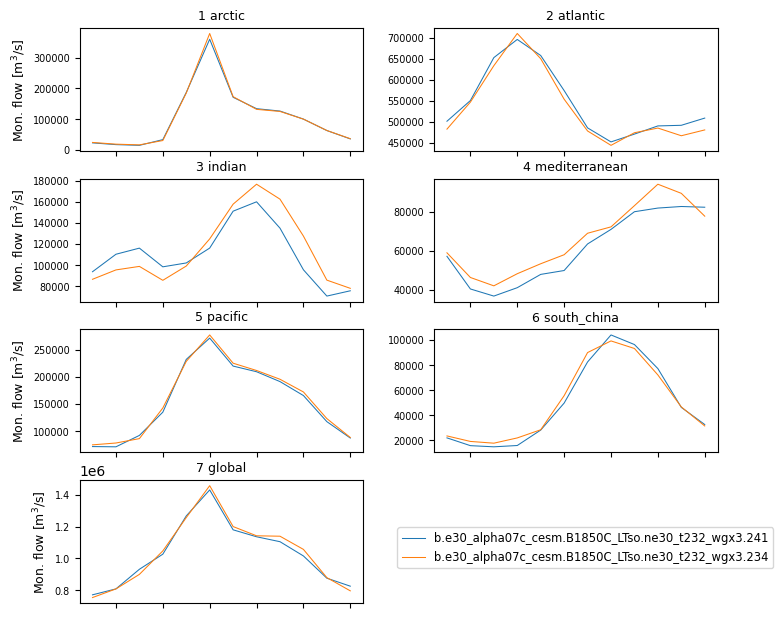

In [15]:
%time

nrows = 4
ncols = 2
fig, axes = plt.subplots(nrows, ncols, figsize=(7.25, 6.5))
plt.subplots_adjust(
    top=0.95, bottom=0.065, right=0.98, left=0.10, hspace=0.225, wspace=0.250
)  # create some space below the plots by increasing the bottom-value

for ix, ocean_name in enumerate(oceans_list):
    row = ix // 2
    col = ix % 2
    for case, meta in case_dic.items():

        q_name = case_meta[meta["grid"]]["flow_name"]

        if case_meta[meta["grid"]]["network_type"] == "vector":
            if ocean_name == "global":
                id_list = gauge_shp1[case]["route_id"].values
            else:
                id_list = gauge_shp1[case][gauge_shp1[case]["ocean"] == ocean_name][
                    "route_id"
                ].values
            reach_index = get_index_array(reachID[case], id_list)
            dr_flow = seas_data[case][q_name].isel(seg=reach_index).sum(dim="seg")
            dr_flow.plot(ax=axes[row, col], linestyle="-", lw=0.75, label=case)

        elif case_meta[grid_name]["network_type"] == "grid":  # means 2d grid
            if ocean_name == "global":
                id_list = gauge_shp1[case]["route_id"].values
            else:
                id_list = gauge_shp1[case][gauge_shp1[case]["ocean"] == ocean_name][
                    "route_id"
                ].values

            reach_index = get_index_array(reachID[case], id_list)
            seas_data_vector = seas_data[case][q_name].stack(seg=("lat", "lon"))
            dr_flow = seas_data_vector.isel(seg=reach_index).sum(dim="seg")
            dr_flow.plot(ax=axes[row, col], linestyle="-", lw=0.75, label=case)

    # reference data
    if obs_available:
        if ocean_name == "global":
            id_list = gauge_shp1[case]["id"].values
        else:
            id_list = gauge_shp1[case][gauge_shp1[case]["ocean"] == ocean_name][
                "id"
            ].values
        gauge_index = get_index_array(ds_q["id"].values, id_list)
        dr_obs = dr_q_obs_seasonal.isel(station=gauge_index).sum(dim="station")
        dr_obs.plot(
            ax=axes[row, col],
            linestyle="None",
            marker="o",
            markersize=2,
            c="k",
            label="D19",
        )

    axes[row, col].set_title("%d %s" % (ix + 1, ocean_name), fontsize=9)
    axes[row, col].set_xlabel("")
    if row < 7:
        axes[row, col].set_xticklabels("")
    if col == 0:
        axes[row, col].set_ylabel("Mon. flow [m$^3$/s]", fontsize=9)
    else:
        axes[row, col].set_ylabel("")
    axes[row, col].tick_params("both", labelsize="x-small")

# Legend- make space below the plot-raise bottom. there will be an label below the second last (bottom middle) ax, thanks to the bbox_to_anchor=(x, y) with a negative y-value.
axes[row, col].legend(
    loc="center left", bbox_to_anchor=(1.10, 0.40, 0.75, 0.1), ncol=1, fontsize="small"
)

for jx in range(ix + 1, nrows * ncols):
    row = jx // 2
    col = jx % 2
    fig.delaxes(axes[row][col])

if figureSave:
    plt.savefig(f"./NB2_Fig1_ocean_discharge_season_{analysis_name}.png", dpi=200)

------
## 5. Plot zonal mean annual dicharge to the oceans <a id='zonal_mean_annual_q'></a>

CPU times: user 1 μs, sys: 1 μs, total: 2 μs
Wall time: 4.29 μs


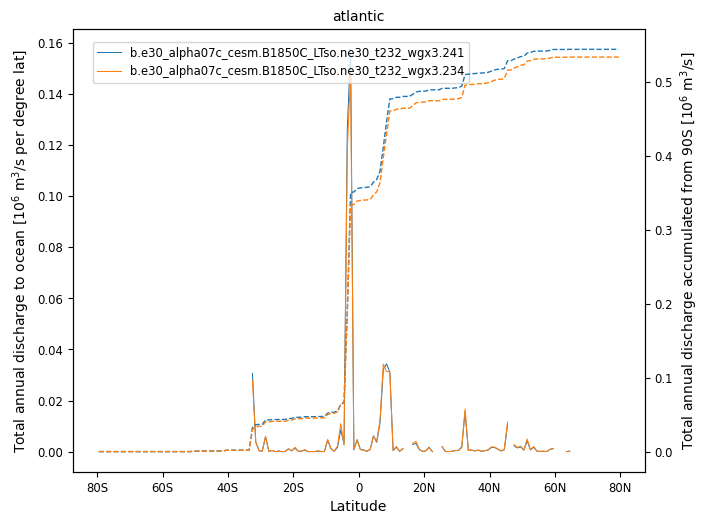

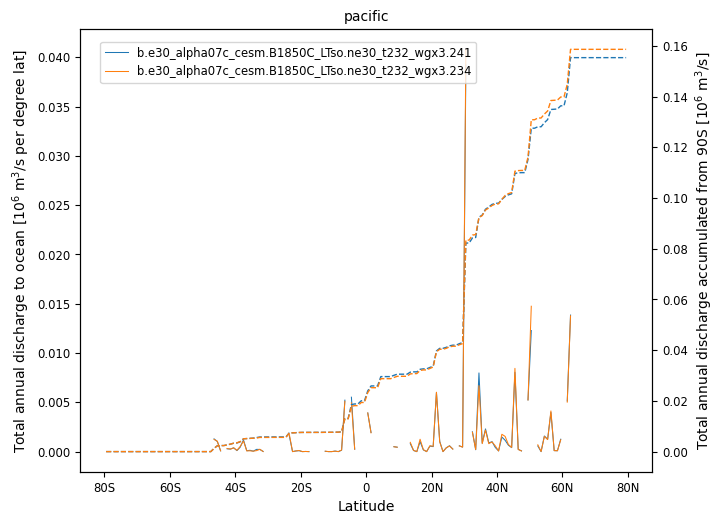

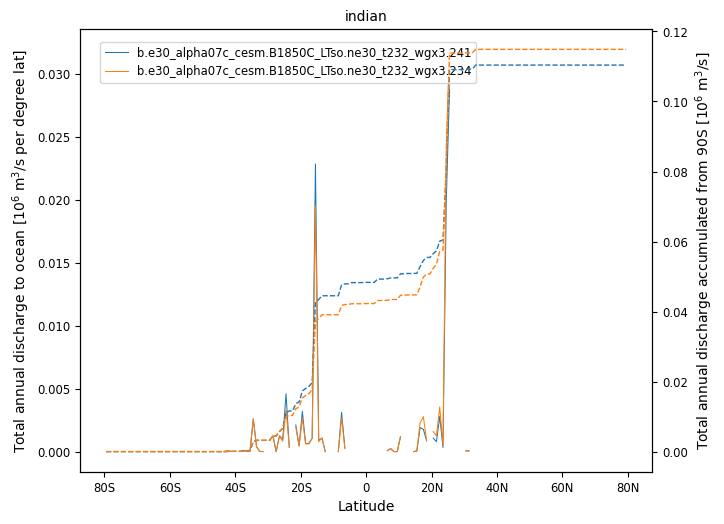

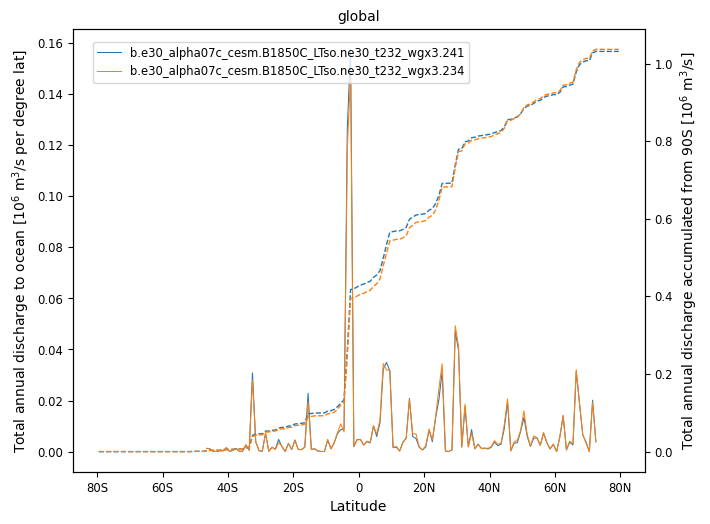

In [16]:
%time
# compute zonal mean total discharge from all the outlets in the modeled river networks.
oceans_list = ["atlantic", "pacific", "indian", "global"]

# Define latitude bins every 1 degree
lat_bins = np.arange(-80, 81, 1.0)
# Compute bin centers for labeling
lat_bin_centers = 0.5 * (lat_bins[:-1] + lat_bins[1:])

for ix, ocean_name in enumerate(oceans_list):

    nrows = 1
    ncols = 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(6.5, 5.0))
    plt.subplots_adjust(
        top=0.95, bottom=0.065, right=0.98, left=0.10, hspace=0.225, wspace=0.250
    )  # create some space below the plots by increasing the bottom-value

    axes_right = axes.twinx()

    for case, meta in case_dic.items():
        grid_name = meta["grid"]
        q_name = case_meta[meta["grid"]]["flow_name"]

        # extract flow data and latitude at outlet locations (index)
        if ocean_name == "global":
            id_list = gauge_shp1[case]["route_id"].values
        else:
            id_list = gauge_shp1[case][gauge_shp1[case]["ocean"] == ocean_name][
                "route_id"
            ].values
        reach_index = get_index_array(reachID[case], id_list)

        if case_meta[grid_name]["network_type"] == "vector":
            # 1. Extract the mapping from riv_ocean (HRU → latitude)
            lat_map = riv_ocean[case].set_index("hruid")["centroid_latitude"]

            # 2. Convert that Series into an xarray DataArray
            lat_da = xr.DataArray(
                lat_map, dims=["hruid"], coords={"hruid": lat_map.index}, name="lat"
            )

            # 3. Align `lat_da` with the reachID coordinate in seas_data
            #    (We assume reachID corresponds to hruid values)
            lat_for_reach = lat_da.sel(
                hruid=xr.DataArray(seas_data[case]["reachID"].values, dims=["seg"])
            )

            # 4. Assign it as a new variable in seas_data
            seas_data[case]["lat"] = lat_for_reach

            ds_flow = seas_data[case][[q_name, "lat"]].isel(seg=reach_index)

            # Group by latitude bins and take the mean across segments in each bin
            zonal_mean = (
                ds_flow[q_name]
                .mean(dim="month")
                .groupby_bins(ds_flow["lat"], bins=lat_bins, labels=lat_bin_centers)
                .sum(dim="seg", skipna=True)
            ) / 1000000

        elif case_meta[grid_name]["network_type"] == "grid":  # means 2d grid

            seas_data_vector = seas_data[case][q_name].stack(seg=("lat", "lon"))
            dr_flow = seas_data_vector.isel(seg=reach_index)
            zonal_mean = (
                dr_flow.mean(dim="month")
                .groupby_bins(dr_flow["lat"], bins=lat_bins, labels=lat_bin_centers)
                .sum(dim="seg", skipna=True)
            ) / 1000000

        # Rename the bin dimension to 'lat' for clarity
        zonal_mean = zonal_mean.rename({"lat_bins": "lat"})
        zonal_mean = zonal_mean.assign_coords(lat=("lat", lat_bin_centers))

        # plot zonal mean discharge per 1-degree lat
        zonal_mean.plot(ax=axes, linestyle="-", lw=0.75, label=case)
        # plot cumulative zonal mean discharge per 1-degree lat
        zonal_mean.cumsum(dim="lat").plot(
            ax=axes_right, linestyle="--", lw=1.0, label=case
        )

    # reference data
    if obs_available:
        if ocean_name == "global":
            id_list = gauge_shp1[case]["id"].values
        else:
            id_list = gauge_shp1[case][gauge_shp1[case]["ocean"] == ocean_name][
                "id"
            ].values
        gauge_index = get_index_array(ds_q["id"].values, id_list)
        dr_obs = dr_q_obs_seasonal.isel(station=gauge_index)
        zonal_mean_obs = (
            dr_obs["FLOW"]
            .mean(dim="month")
            .groupby_bins(dr_obs["lat"], bins=lat_bins, labels=lat_bin_centers)
            .sum(dim="station", skipna=True)
        ) / 1000000

        zonal_mean_obs.plot(
            ax=axes,
            linestyle="None",
            marker="o",
            markersize=2,
            c="k",
            label="D19",
            zorder=0,
        )

    axes.set_title("%s" % (ocean_name), fontsize=10)
    axes.set_xlabel("Latitude")

    axes.set_xticks(np.arange(-80, 81, 20))
    axes.set_xticklabels(["80S", "60S", "40S", "20S", "0", "20N", "40N", "60N", "80N"])
    axes.set_ylabel(
        "Total annual discharge to ocean [10$^6$ m$^3$/s per degree lat]", fontsize=10
    )
    axes.tick_params("both", labelsize="small")

    axes_right.set_ylabel(
        "Total annual discharge accumulated from 90S [10$^6$ m$^3$/s]", fontsize=10
    )
    axes_right.tick_params("both", labelsize="small")

    # Legend- make space below the plot-raise bottom. there will be an label below the second last (bottom middle) ax, thanks to the bbox_to_anchor=(x, y) with a negative y-value.
    axes.legend(
        loc="center left",
        bbox_to_anchor=(0.025, 0.875, 0.75, 0.1),
        ncol=1,
        fontsize="small",
    )

    if figureSave:
        plt.savefig(
            f"./NB2_Fig3_global_zonal_mean_annal_discharge_{ocean_name}_{analysis_name}_gauge_only.png",
            dpi=300,
        )

In [17]:
if client:
    client.shutdown()
    print("Dask client shutdown complete.")

Dask client shutdown complete.
